In [1]:
from encoder import *
from decoder import *
from dataset import *

In [2]:
encoder_config = EncoderConfig(
    image_size=128,
    hidden_size=512,
    intermediate_size=512 * 3,
    num_hidden_layers=8,
    num_attention_heads=8,
    num_channels=3,
    patch_size=8,
    layer_norm_eps=1e-6,
    attention_dropout=0.0,
    num_image_tokens=None,
    do_random_mask=True,
    mask_ratio=0.75
)


decoder_config = DecoderConfig(
    image_size=128,
    in_proj_dim=512,
    hidden_size=512,
    intermediate_size=512 * 3,
    num_hidden_layers=8,
    num_attention_heads=8,
    num_channels=3,
    patch_size=8,
    layer_norm_eps=1e-6,
    attention_dropout=0.0,
    num_image_tokens=None    
)

In [3]:
encoder = EncoderModel(encoder_config)
decoder = DecoderModel(decoder_config)

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
img, class_name = next(iter(train_dataloader))
img.shape, class_name

(torch.Size([1, 3, 128, 128]), ('unlabeled',))

In [6]:
encoder_op, mask, ids_restore = encoder(img)
decoder_op = decoder((encoder_op, mask, ids_restore), img)

In [7]:
decoder_op[0].shape, decoder_op[1]

(torch.Size([1, 3, 128, 128]), tensor(2.1227, grad_fn=<MseLossBackward0>))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2606754..1.9503922].


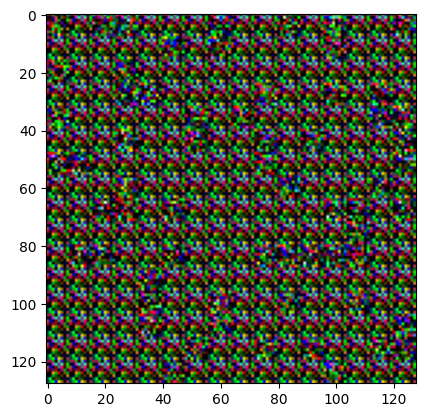

In [8]:
import matplotlib.pyplot as plt
plt.imshow(decoder_op[0].squeeze(0).detach().cpu().permute(1, 2, 0));

In [15]:
torch.save(encoder.state_dict(), 'encoder.pth')